## Import the data

In [509]:

# Pandas for data processing
import pandas as pd

# Meteostat model
from meteostat import Stations, Daily


# Skearn modules
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Statsmodels for initial regression models
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.iolib.summary2 import summary_col

# Yahoo Finance for data
import yfinance as yf


# Date and timer 
from datetime import datetime
import time


# Packages to plot
import matplotlib.pyplot as plt
import seaborn as sns

# Data initialization

### I have installed meteostat which a free python library containing free data, given stationpoints around the world

- First I need a way to find the name of the city and get the Latitude and longitude data for that city

- There is some data that I am missing. The prices are moving together but I feel there are some other regions I am missing. Looking online I saw that Columbia which is Geographically close to Brazil is also a major coffee producers

- I downloaded the data for Colombia from the same website

- I downloaded the data from: https://simplemaps.com/data/br-cities

I have the csv files as is and imported it into the code 

In [454]:
br_cities = pd.read_csv('./br.csv')
co_cities = pd.read_csv('./co.csv')
#Now I have cities where I have regions in Brazil and Colombia
cities = pd.concat([br_cities,co_cities])

In [455]:
cities.tail()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
79,Leticia,-4.2167,-69.9333,Colombia,CO,Amazonas,admin,33503.0,32450.0
80,La Virginia,4.9167,-75.8333,Colombia,CO,Risaralda,minor,32330.0,32330.0
81,Mitú,1.1983,-70.1733,Colombia,CO,Vaupés,admin,28382.0,28382.0
82,Inírida,3.8653,-67.9239,Colombia,CO,Guainía,admin,20279.0,19816.0
83,Puerto Carreño,6.1903,-67.4836,Colombia,CO,Vichada,admin,16763.0,16763.0


## Brazil's coffee production
#### Since Brazil is a big country I want to narrow down where the production actually happens
According to USDA report on Table 2: https://apps.fas.usda.gov/newgainapi/api/Report/DownloadReportByFileName?fileName=Coffee%20Semi-annual_Brasilia_Brazil_BR2023-0031

We have access to states where most of the coffee farming happens. These states are:
- Mina Gerias with 33.1 Million kg bags in 2023
- Sao Paulo with 5.6 Million kg bags in 2023
- Espitito Santo (mostly Rubusta)

**Another big producer of Coffee in the same region is Colombia, I would love to have some data for Columbia as well.**
Regions with coffe production in Columbia also called the Coffee triable


https://ourworld.unu.edu/en/climate-change-impacts-to-drive-up-coffee-prices

https://www.nasdaq.com/articles/arabica-coffee-prices-strengthen-on-dry-conditions-in-brazil

- Antioquia
- Huila
- Tolima 

**With that knowledge I will close down on weather data for the cities in those regions!**



In [456]:
admin = cities['admin_name'].value_counts()
admin.head(10)

admin_name
São Paulo              23
Bahia                  19
Maranhão               12
Ceará                  11
Antioquia              11
Cundinamarca           10
Pernambuco              9
Minas Gerais            9
Rio Grande do Norte     8
Rio Grande do Sul       7
Name: count, dtype: int64

In [457]:
regions = ['Minas Gerais','São Paulo']
#,'Tolima','São Paulo','Hulia','Antioquia'
city = cities[cities['admin_name'].isin(regions)]
city.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,São Paulo,-23.5500,-46.6333,Brazil,BR,São Paulo,admin,23086000.0,12252023.0
2,Belo Horizonte,-19.9167,-43.9333,Brazil,BR,Minas Gerais,admin,5328000.0,2502557.0
7,Santos,-23.9369,-46.3250,Brazil,BR,São Paulo,NaN,1897551.0,418608.0
12,Guarulhos,-23.4628,-46.5328,Brazil,BR,São Paulo,NaN,1324781.0,1324781.0
14,Campinas,-22.9058,-47.0608,Brazil,BR,São Paulo,NaN,1213792.0,1213792.0


### Here I am downloading the average tempratures and precipitation data for the regions in Brazil where we have most of the coffee produciton. 

I have daily weather data starting from **2019** unitl end of **2023** from the closest stations where data is available in these regions/citites. 

In [458]:
start = datetime(2021, 1, 1)
end = datetime(2024, 1, 1)
#empty dataframe
wdata = pd.DataFrame()
ix = 0

for i in city['city']:
    #The servers used are free but we don't want them to be overloaded with data collection and the code to crash. So I have put a timer between entries!
    time.sleep(0.1)
    name = i
    #Getting latitude and longitude values for each cities in our dataset
    lat = city.loc[city['city'] == i, 'lat'].values[0]
    lng = city.loc[city['city'] == i, 'lng'].values[0]

    #Calling the station
    stations = Stations()
    #Plugging in the lat and lon values for the city
    stations = stations.nearby(lat, lng)
    station = stations.fetch(1)  # Fetch closest station

    # Fetch daily historical data for the specified station and time period
    name = Daily(station, start, end)
    name = name.fetch()
    # Select only the columns for temperature and precipitation
    name = name[['tavg','prcp']]
    #Putting time index as a column so we can merge easily
    name.reset_index(inplace=True)
    #Renaming the columns so we have a better idea which column has the data for which city
    name = name.rename(columns={'tavg':f'tavg_{i}'})
    name = name.rename(columns={'prcp':f'prcp_{i}'})
    #wdata is ann empty dataset. The first time I want it to take the values of the first city, and then after merge new cities into it
    if ix == 0:
        wdata = name.copy()
        ix +=1
    else:
        wdata = wdata.merge(name,right_on='time',left_on='time',how='left')

wdata = wdata.drop_duplicates(subset='time')
# So when we divide the data later both have the dates

### Saving a copy of the file, just in case the servers aren't functionning

In [459]:
wdata = wdata.set_index('time')
wdata.to_csv('weather.csv', index=False)

#### I want the data to be divided between precepitaion data and average temprature data

In [460]:
prcp_columns = [col for col in wdata.columns if col.startswith('prcp')]
# Create a new DataFrame with these columns
prcp_df = wdata[prcp_columns]
prcp_df['Average prcp'] = prcp_df.mean(axis=1, skipna=True)
prcp_df.reset_index(inplace=True)

tavg_columns = [col for col in wdata.columns if col.startswith('tavg')]
# Create a new DataFrame with these columns
tavg_df = wdata[tavg_columns]
tavg_df['Average Temperature'] = tavg_df.mean(axis=1, skipna=True)

ext = tavg_df[tavg_df['Average Temperature']>= 24.5]# extreme weather cases 



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Coffee Prices specifically Arabica, the coffee beans that is produced in Brazil

I want the data for the same time periodes as the weather data available to me

**Note that these are worldwide coffee prices of *Arabica* and not just Brazil's.** As we have seen before Brazil's produces 40% of world's coffee beans so it must have 

In [461]:
arabica = "KC=F"

price = yf.download(arabica,start,end)
price.reset_index(inplace=True)


price['AVG_Price'] = (price['High'] + price['Low']) / 2
price = price[['Date','AVG_Price','Volume']]

brazil = "BRL=X"
exchange = yf.download(brazil,start,end)
exchange.reset_index(inplace=True)

exchange['exchange'] = (exchange['High'] + exchange['Low']) / 2
exchange = exchange[['Date','exchange','Volume']]




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


I am now merging everything together in here

In [462]:
main = pd.merge(tavg_df,prcp_df,right_on='time',left_on='time',how ='inner')
main = main.merge(price, right_on='Date',left_on='time',how ='inner')
main = main.merge(exchange, right_on='Date',left_on='Date',how ='inner') 
main = main.drop_duplicates(subset='time')
main['Adj_Price'] = main['exchange'] * main['AVG_Price']

main['return'] = main['AVG_Price'].pct_change()*100
main['cum_return'] = main['return'].cumsum()

main['lagged_price'] = main['Adj_Price'].shift(50)
main = main.dropna(subset='lagged_price')


main['lag_return'] = main['Adj_Price'].pct_change()
main['cum_lag_return'] = main['lag_return'].cumsum()


main['Extereme'] = ext['Average Temperature']
main.head()

,time,tavg_São Paulo,tavg_Belo Horizonte,tavg_Santos,tavg_Guarulhos,tavg_Campinas,tavg_Santo André,tavg_Osasco,tavg_Contagem,tavg_Mauá,...,Volume_x,exchange,Volume_y,Adj_Price,return,cum_return,lagged_price,lag_return,cum_lag_return,Extereme
50,2021-03-17,25.0,26.1,26.6,23.8,25.1,24.3,25.0,23.0,24.3,...,1,5.647465,0,748.289048,1.338432,4.483153,660.129163,NaN,NaN,NaN
51,2021-03-18,23.0,23.3,26.2,22.3,23.4,22.9,23.0,23.2,22.9,...,9,5.530350,0,727.241021,-0.754717,3.728436,661.001599,-0.028128,-0.028128,NaN
52,2021-03-19,22.4,23.7,25.3,21.9,23.7,22.3,22.4,23.2,22.3,...,19903,5.511300,0,691.392549,-4.600763,-0.872327,650.936729,-0.049294,-0.077422,NaN
53,2021-03-22,24.8,24.0,26.3,23.7,25.7,25.2,24.8,23.3,25.2,...,17089,5.506870,0,708.596436,2.570747,1.698420,647.754774,0.024883,-0.052539,NaN
54,2021-03-23,24.8,24.4,26.4,23.7,25.9,23.8,24.8,24.4,23.8,...,15769,5.509381,0,710.847899,0.272005,1.970425,652.627592,0.003177,-0.049362,NaN


Here I have daily weather data for each state row wise

In [463]:
#This changes the DataFrame from a wide format to a long format where each 
#row represents a single observation, making it easier to plot using functions that expect data in this format.
df_melted = tavg_df.reset_index().melt(id_vars='time', var_name='City', value_name='Temperatures')

df = df_melted.merge(main, right_on='Date',left_on='time',how='inner')
df_melted.head()

,time,City,Temperatures
0,2021-01-01,tavg_São Paulo,21.7
1,2021-01-02,tavg_São Paulo,21.1
2,2021-01-03,tavg_São Paulo,21.1
3,2021-01-04,tavg_São Paulo,22.4
4,2021-01-05,tavg_São Paulo,24.8


# Data visualization

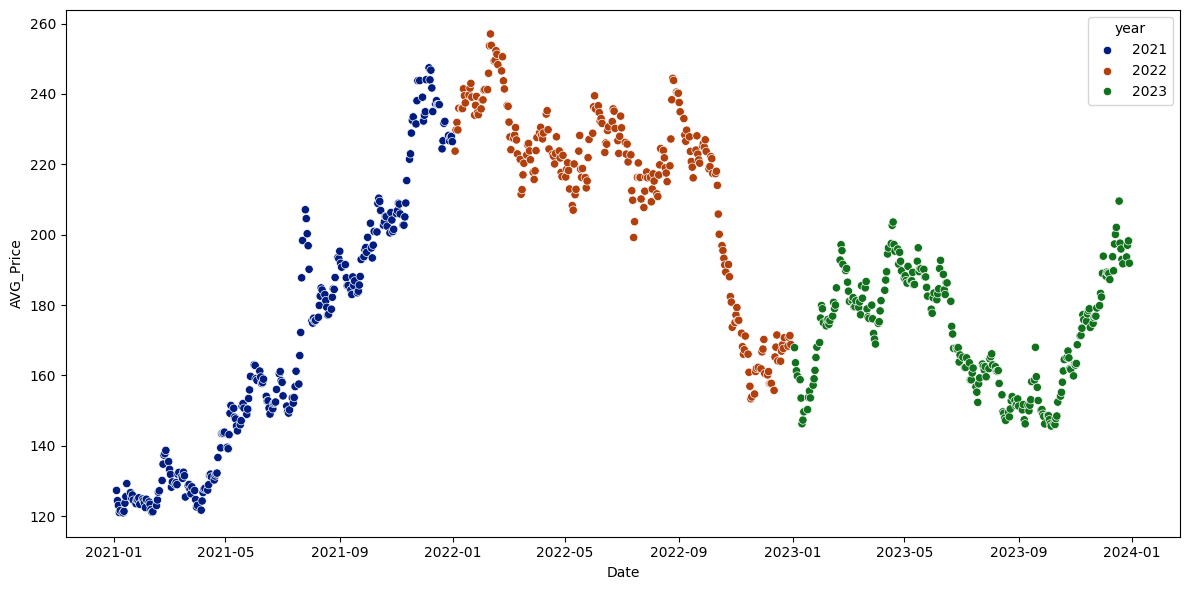

In [464]:
# This condition selects rows where the month is not March or April
filtered_df = main[(main['time'].dt.month != 6) & (main['time'].dt.month != 7)& (main['time'].dt.month != 8)]

price['year'] = price['Date'].dt.year  # Extracting year from date

fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=price, x='Date', y='AVG_Price',hue='year', ax=axs,palette='dark')

# Adjust layout
plt.tight_layout()
plt.show()

## Temprature Data

The plot bellow shows the average temrature changes accross cities and time. We can clearly see that the tempratures across this region is quite similar. We don't have major outliers where the temprature of one city is much higher or lower then the average. 
We have a total average of around **22.3°C**

Further more we can see that the temprature has a **V** shape, where in summer the tempratures are high and in winter they are quite low. In general however, the tempratures are quite stable in this region. 

If we want to look at the average temprature for all the citis across time in figure 2 we see much clearly the **V** shape we are talking about.

The average tempratures across cities are much more stable, where we see a low of around **16°C** and a high of **24°C**

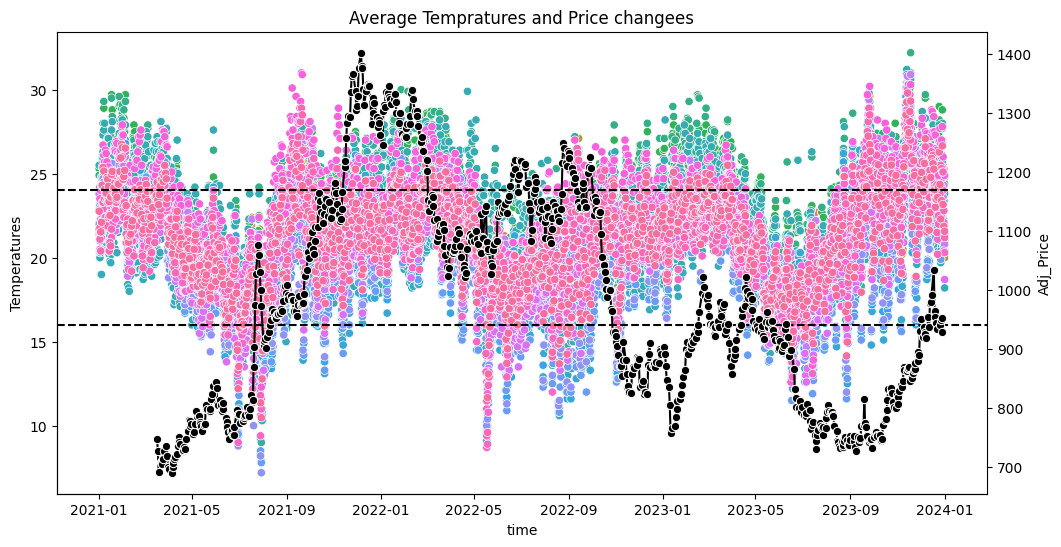

<Figure size 1500x600 with 0 Axes>

In [465]:
fig, axs = plt.subplots(figsize=(12, 6))

# Computing the temprature mean across cities and time.
average_temp = tavg_df['Average Temperature'].mean()

# Create a plot using Seaborn
plt.figure(figsize=(15, 6))
sns.scatterplot(data=df_melted, x='time', y='Temperatures', hue='City',legend=False,ax=axs)

ax2 = axs.twinx()
sns.lineplot(data=main, x='Date', y='Adj_Price',color='black',marker='o',ax = ax2)


axs.set_title('Average Tempratures and Price changees')
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

axs.axhline(y=24,color='black',linestyle='--')
axs.axhline(y=16,color='black',linestyle='--')

# Show the plot
plt.show()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


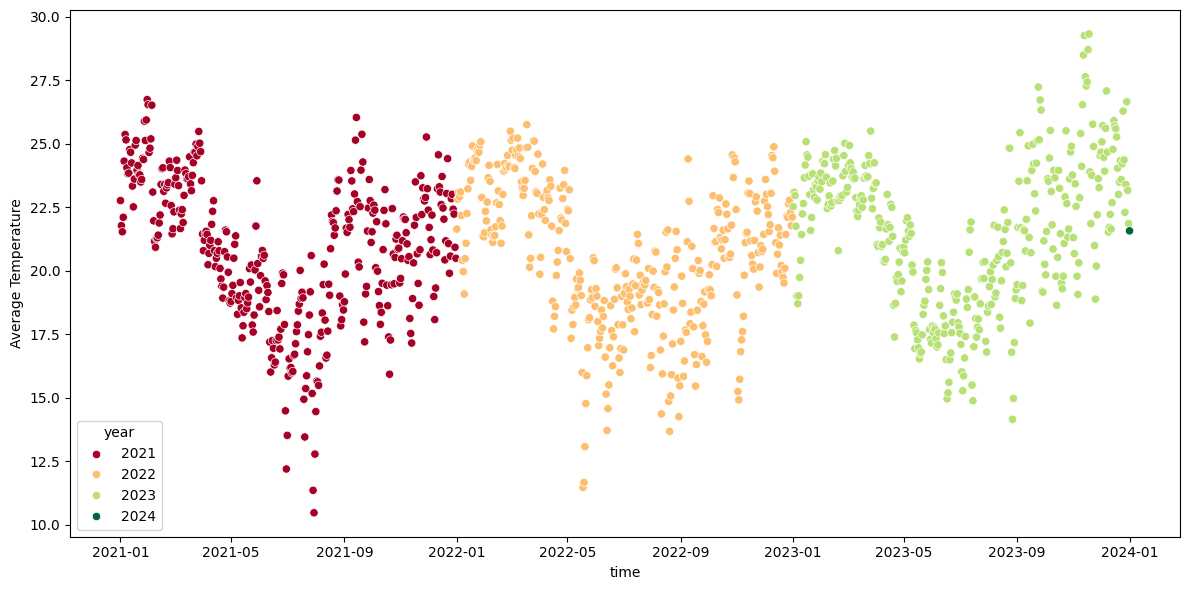

In [466]:
tavg_df.reset_index(inplace=True)
tavg_df['year'] = tavg_df['time'].dt.year  # Extracting year from date
fig, axs = plt.subplots(figsize=(12, 6))


sns.scatterplot(data=tavg_df, x='time', y='Average Temperature',hue='year', ax=axs,palette='RdYlGn')

# Adjust layout
plt.tight_layout()
plt.show()


## Precipitation Data

Here we see that for before 2021, we have very little data, most of it is set at zero or the data doesn't even exists. Further more we have huge outliers, where we have precipitation of 40 to 50 mm, for years before 2021 which does seem a bit odd. 

I believe this is because of data issue, and that the server might have errors for precipitation data before 2021.

I will there for cut to years after 2021, to see how the data looks

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


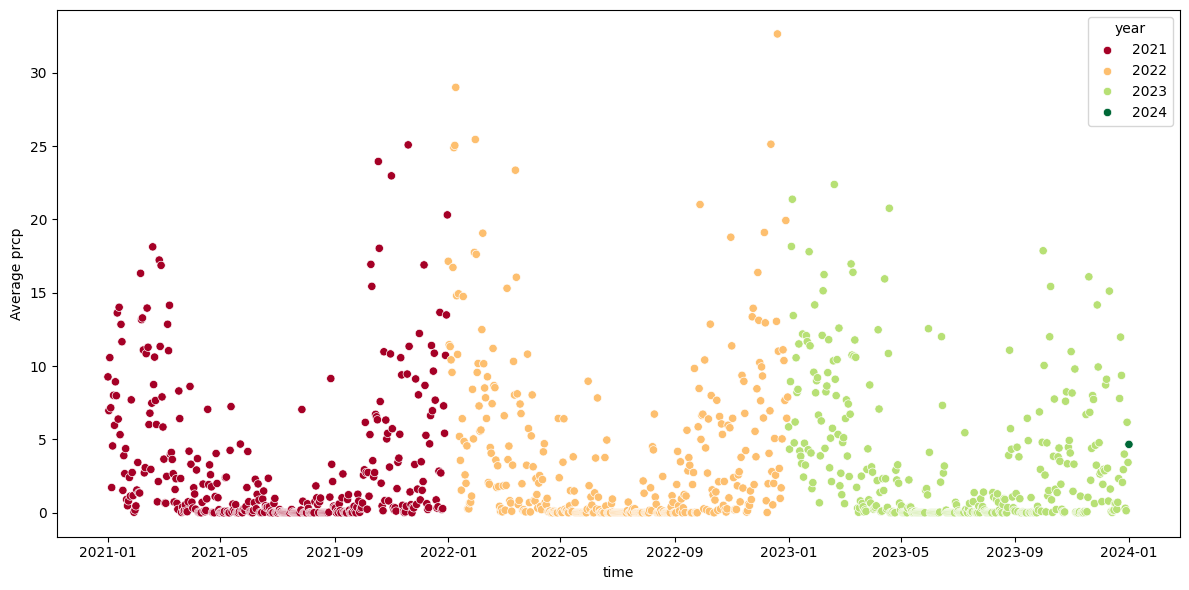

In [467]:
prcp_df['year'] = prcp_df['time'].dt.year  # Extracting year from date
fig, axs = plt.subplots(figsize=(12, 6))


sns.scatterplot(data=prcp_df, x='time', y='Average prcp',hue='year', ax=axs,palette='RdYlGn')

# Adjust layout
plt.tight_layout()
plt.show()


Now that we look at the precipitation data for year **2021** onwards, we can see a **U** shapes. There is very little precipitation in the summer but in winter seasen there are a lot of rainfall, especially in year 2022, with high precipitation

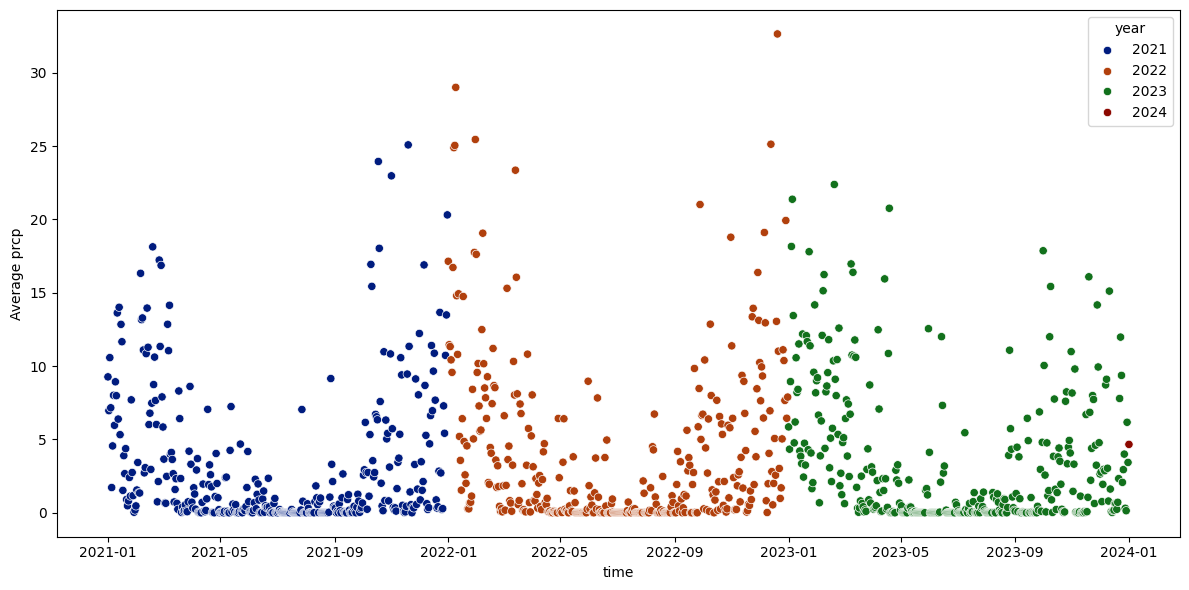

In [468]:
newprcp_df = prcp_df[prcp_df['year']>=2021]

fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=newprcp_df, x='time', y='Average prcp',hue='year', ax=axs,palette='dark')

# Adjust layout
plt.tight_layout()
plt.show()

## Comparing Weather to returns

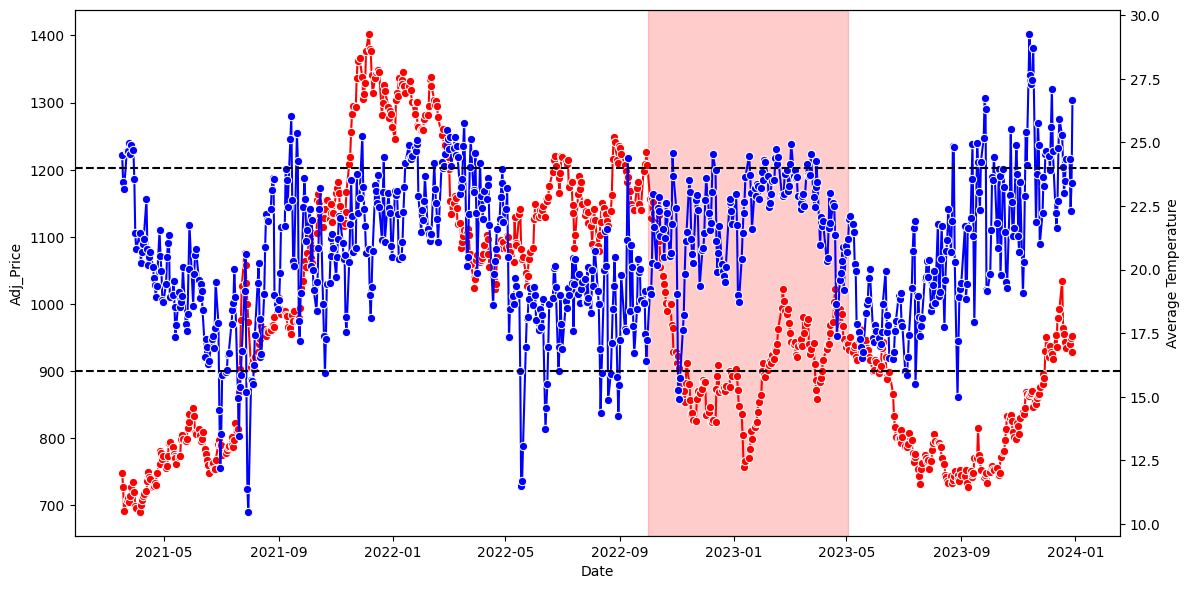

In [469]:
#main.set_index('Date', inplace=True)
fig, axs = plt.subplots(figsize=(12, 6))


sns.lineplot(data=main, x='Date', y='Adj_Price', ax=axs,color='red',marker='o')
axs2 = axs.twinx()
sns.lineplot(data=main, x='time', y='Average Temperature', ax=axs2, color='blue',marker='o')

axs.axvspan(pd.Timestamp('2022-10-01'), pd.Timestamp('2023-05-03'), color='red', alpha=0.2)

axs2.axhline(y=24,color='black',linestyle='--')
axs2.axhline(y=16,color='black',linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()

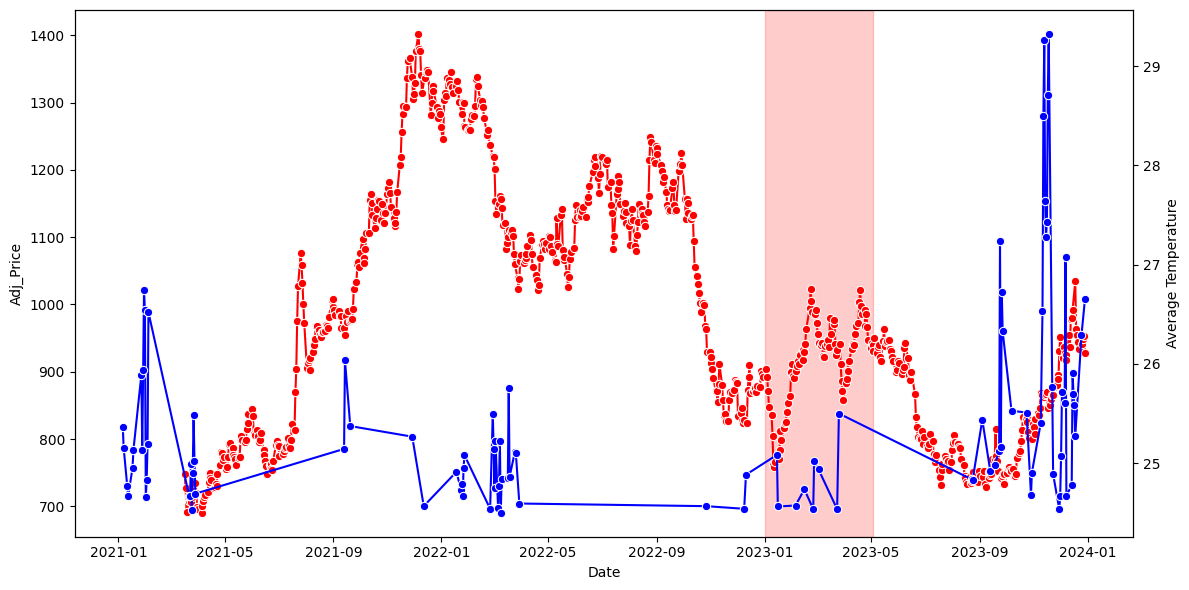

In [470]:
fig, axs = plt.subplots(figsize=(12, 6))

sns.lineplot(data=main, x='Date', y='Adj_Price', ax=axs,color='red',marker='o')
axs2 = axs.twinx()
sns.lineplot(data=ext, x='time', y='Average Temperature', ax=axs2, color='blue',marker='o')

axs.axvspan(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-05-03'), color='red', alpha=0.2)
# Adjust layout
plt.tight_layout()
plt.show()


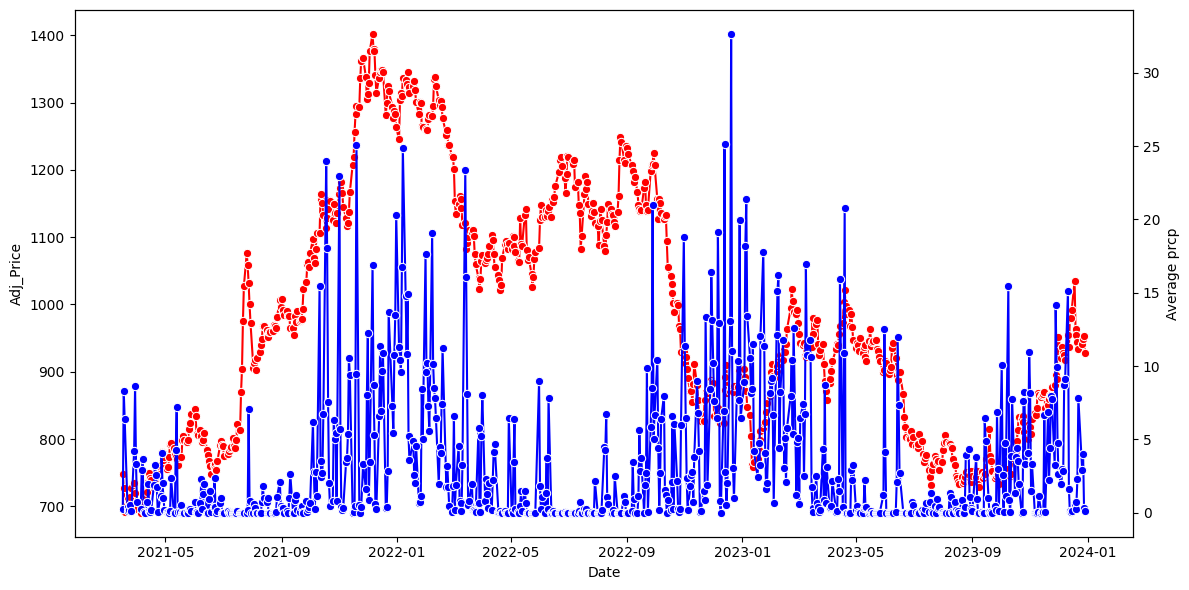

In [471]:
fig, axs = plt.subplots(figsize=(12, 6))


sns.lineplot(data=main, x='Date', y='Adj_Price', ax=axs,color='red',marker='o')
axs2 = axs.twinx()
sns.lineplot(data=main, x='time', y='Average prcp', ax=axs2, color='blue',marker='o')

# Adjust layout
plt.tight_layout()
plt.show()

# Running some regressions to look for some correlations

## Regression plots

Text(0, 0.5, 'Cummulative Lagged returns (50Days) returns on Coffee beans')

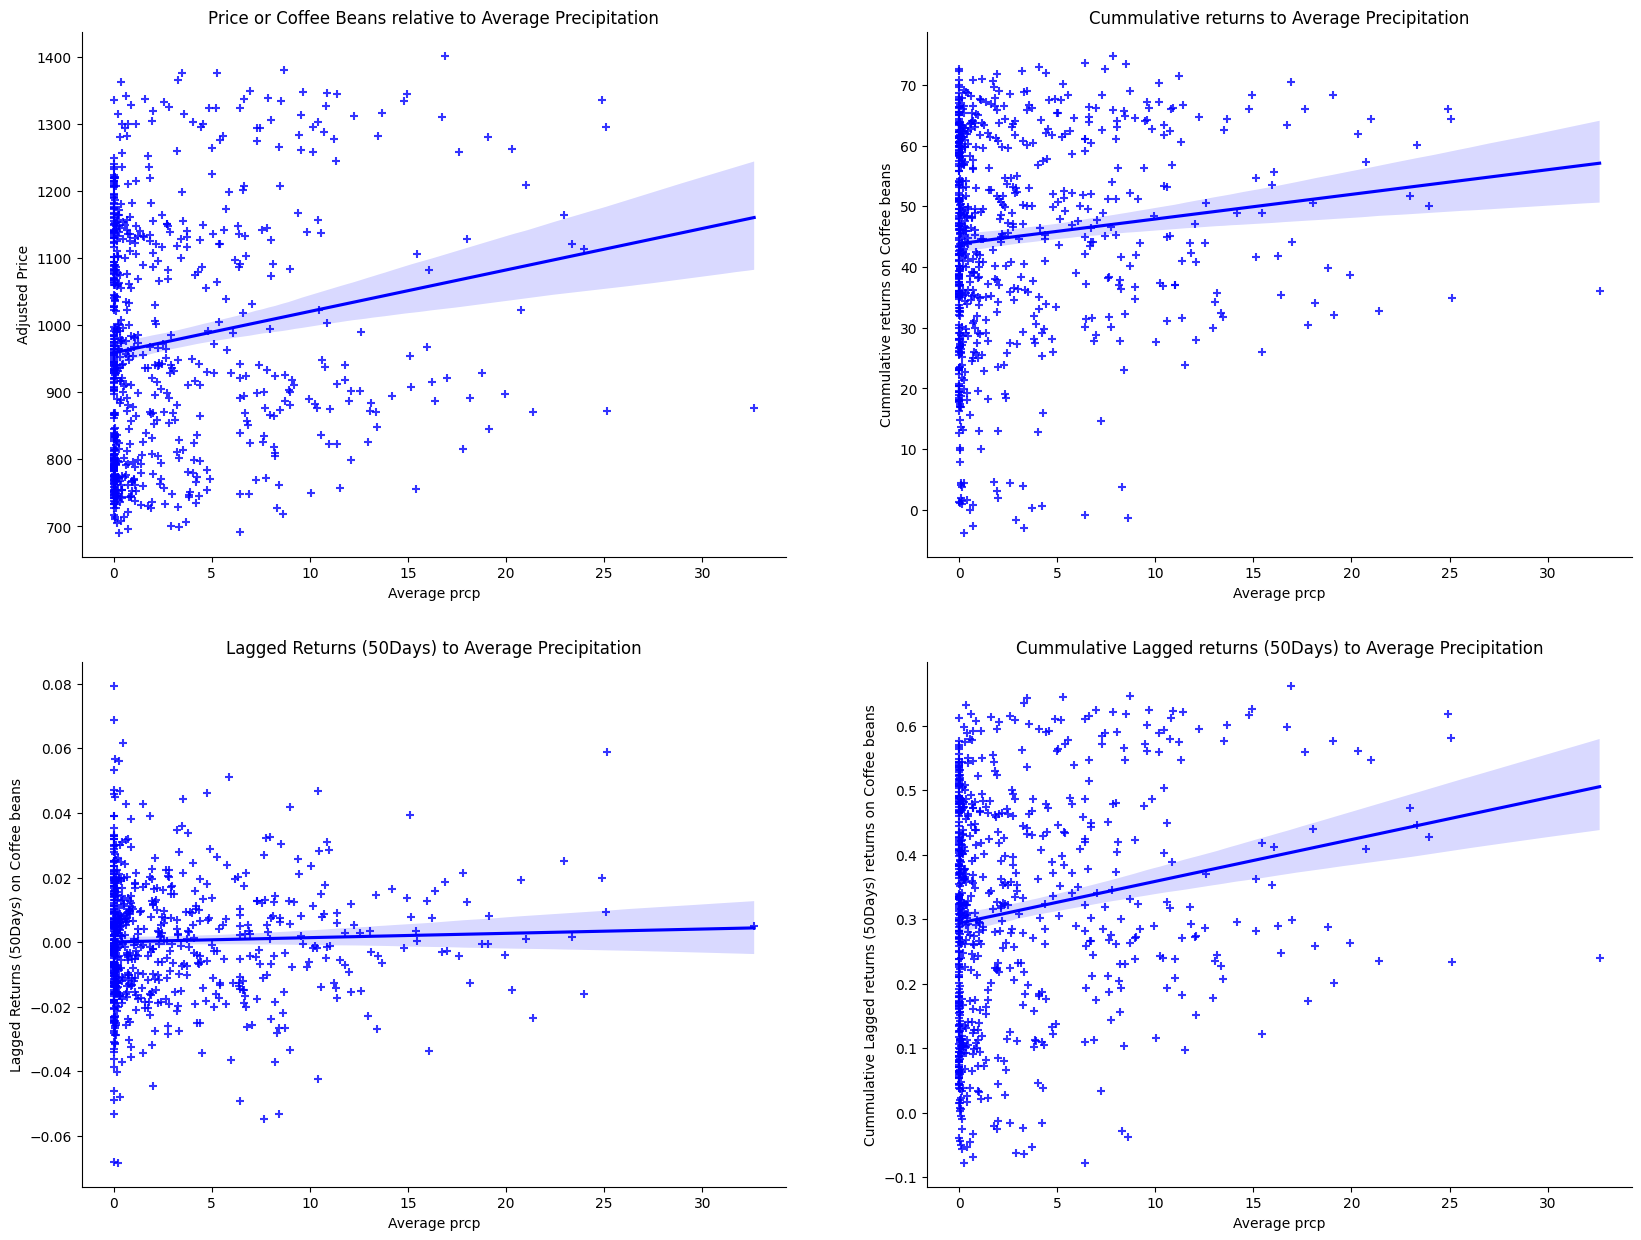

In [472]:
fig, ax = plt.subplots(figsize=(20,15) ,ncols=2, nrows=2)

sns.regplot(x='Average prcp', y='Adj_Price', data=main, color='blue', marker='+',ax= ax[0][0])
sns.regplot(x='Average prcp', y='cum_return', data=main, color='blue', marker='+',ax = ax[0][1])
sns.regplot(x='Average prcp', y='lag_return', data=main, color='blue', marker='+',ax = ax[1][0])
sns.regplot(x='Average prcp', y='cum_lag_return', data=main, color='blue', marker='+',ax = ax[1][1])




ax[0][0].set_title('Price or Coffee Beans relative to Average Precipitation')
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)
ax[0][0].set_ylabel("Adjusted Price")


ax[0][1].set_title('Cummulative returns to Average Precipitation')
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][1].set_ylabel("Cummulative returns on Coffee beans")

ax[1][0].set_title('Lagged Returns (50Days) to Average Precipitation')
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['top'].set_visible(False)
ax[1][0].set_ylabel("Lagged Returns (50Days) on Coffee beans")

ax[1][1].set_title('Cummulative Lagged returns (50Days) to Average Precipitation')
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].set_ylabel("Cummulative Lagged returns (50Days) returns on Coffee beans")


Text(0, 0.5, 'Cummulative Lagged returns (50Days) returns on Coffee beans')

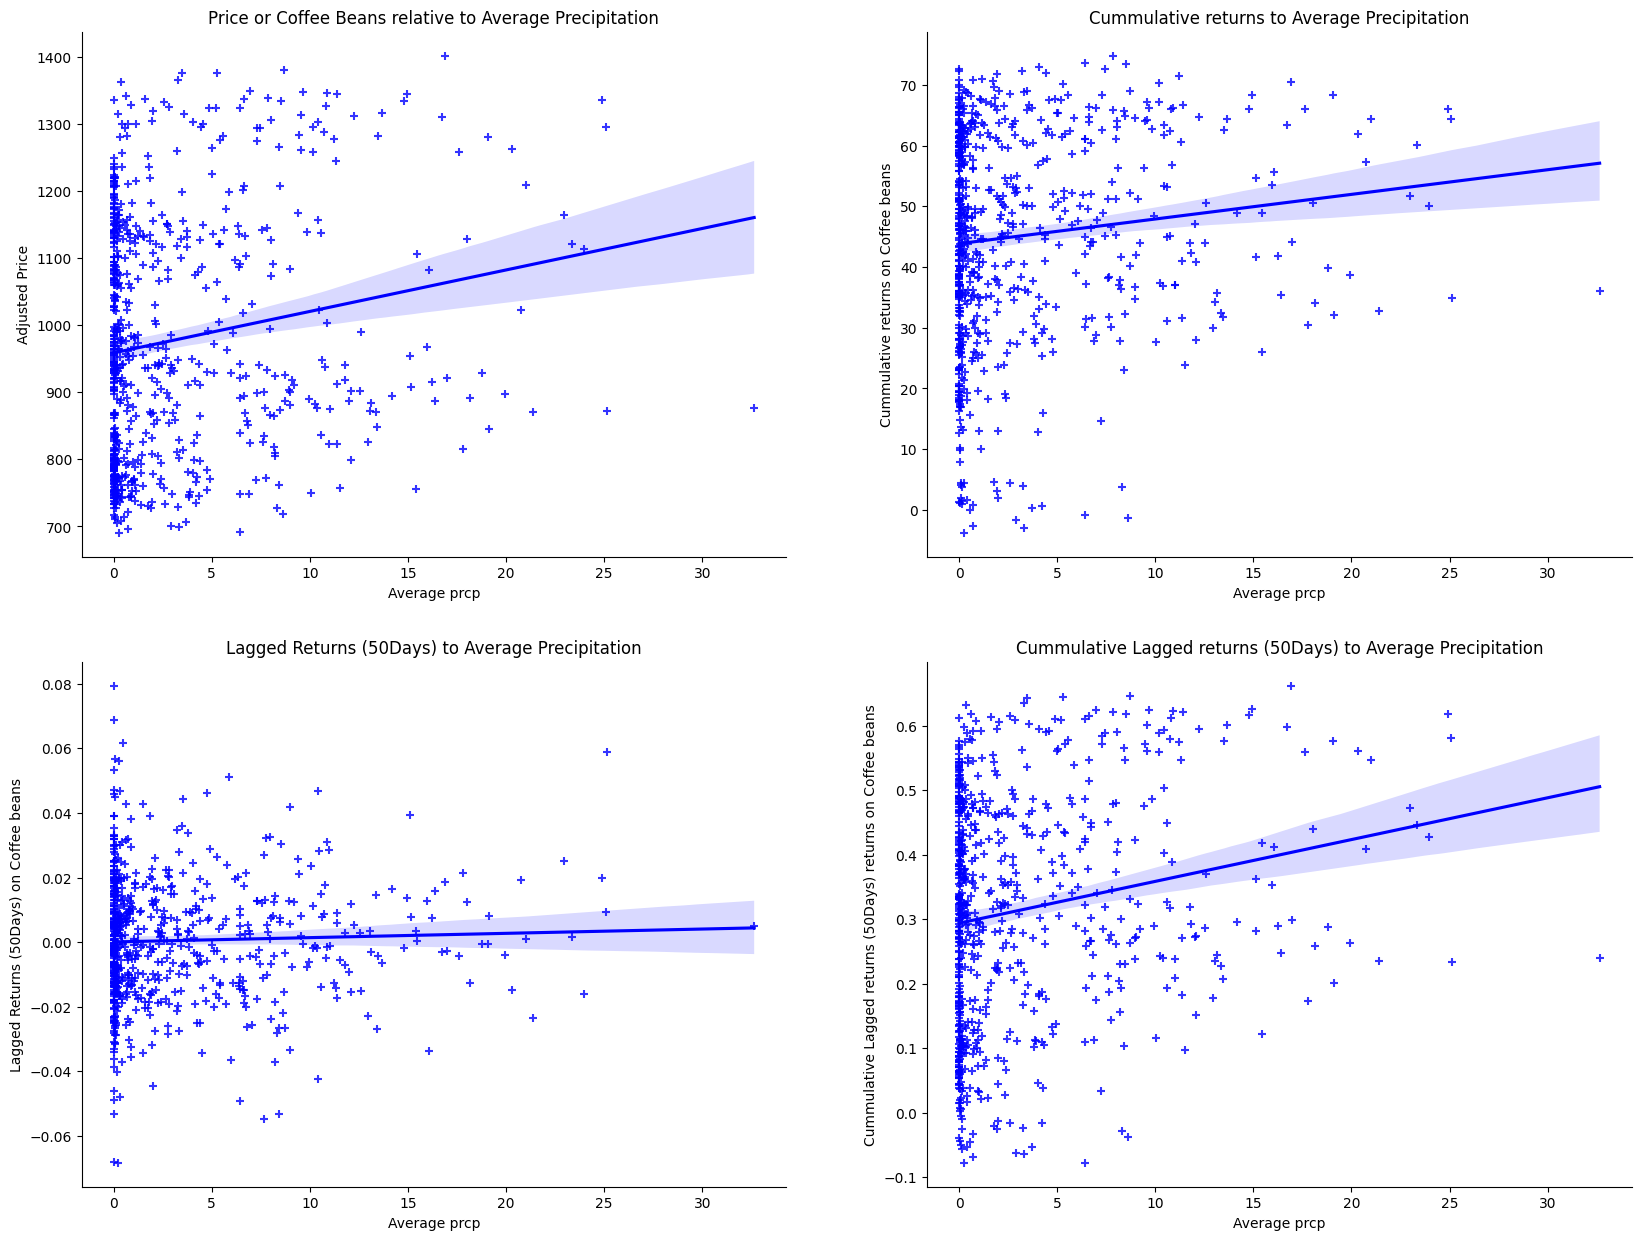

In [473]:
fig, ax = plt.subplots(figsize=(20,15) ,ncols=2, nrows=2)

sns.regplot(x='Average prcp', y='Adj_Price', data=main, color='blue', marker='+',ax= ax[0][0])
sns.regplot(x='Average prcp', y='cum_return', data=main, color='blue', marker='+',ax = ax[0][1])
sns.regplot(x='Average prcp', y='lag_return', data=main, color='blue', marker='+',ax = ax[1][0])
sns.regplot(x='Average prcp', y='cum_lag_return', data=main, color='blue', marker='+',ax = ax[1][1])




ax[0][0].set_title('Price or Coffee Beans relative to Average Precipitation')
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)
ax[0][0].set_ylabel("Adjusted Price")


ax[0][1].set_title('Cummulative returns to Average Precipitation')
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][1].set_ylabel("Cummulative returns on Coffee beans")

ax[1][0].set_title('Lagged Returns (50Days) to Average Precipitation')
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['top'].set_visible(False)
ax[1][0].set_ylabel("Lagged Returns (50Days) on Coffee beans")

ax[1][1].set_title('Cummulative Lagged returns (50Days) to Average Precipitation')
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].set_ylabel("Cummulative Lagged returns (50Days) returns on Coffee beans")


Text(0, 0.5, 'Cummulative Lagged returns (50Days) returns on Coffee beans')

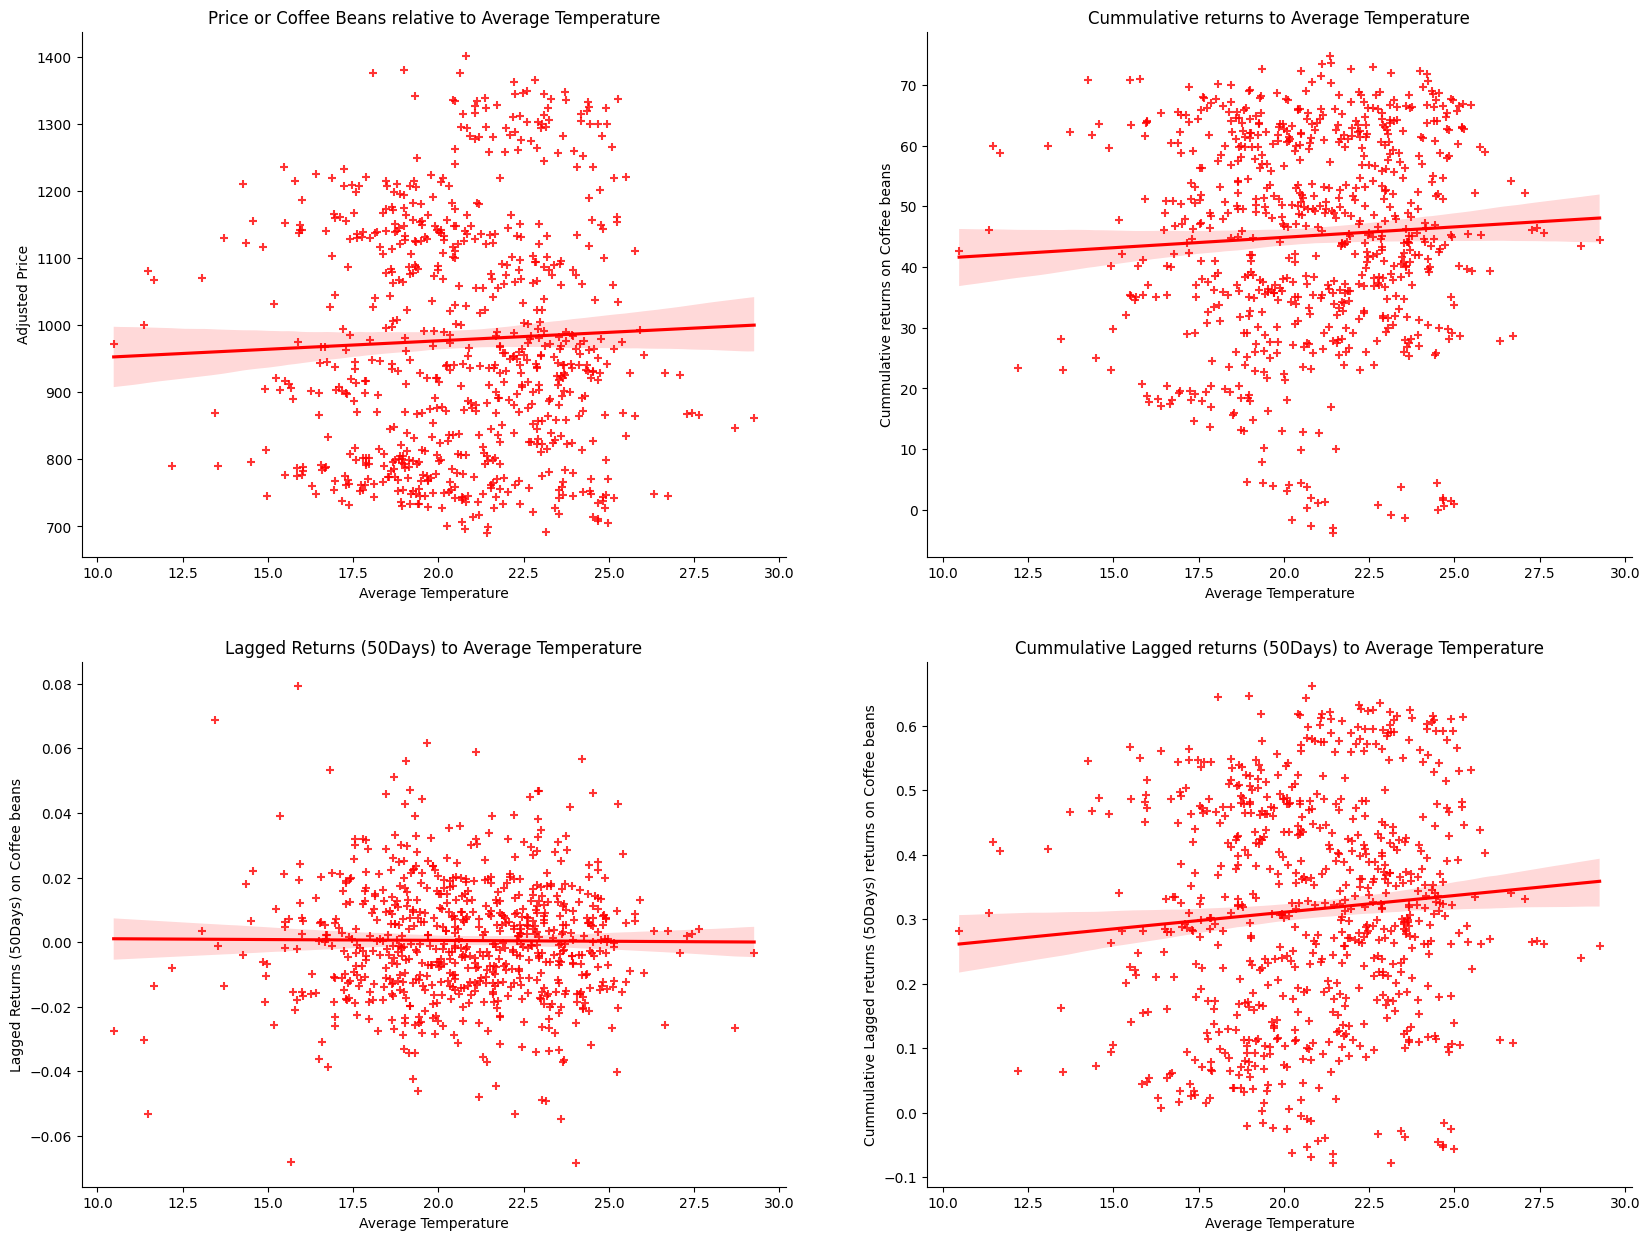

In [474]:
fig, ax = plt.subplots(figsize=(20,15) ,ncols=2, nrows=2)

sns.regplot(x='Average Temperature', y='Adj_Price', data=main, color='red', marker='+',ax= ax[0][0])
sns.regplot(x='Average Temperature', y='cum_return', data=main, color='red', marker='+',ax = ax[0][1])
sns.regplot(x='Average Temperature', y='lag_return', data=main, color='red', marker='+',ax = ax[1][0])
sns.regplot(x='Average Temperature', y='cum_lag_return', data=main, color='red', marker='+',ax = ax[1][1])


ax[0][0].set_title('Price or Coffee Beans relative to Average Temperature')
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)
ax[0][0].set_ylabel("Adjusted Price")


ax[0][1].set_title('Cummulative returns to Average Temperature')
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][1].set_ylabel("Cummulative returns on Coffee beans")

ax[1][0].set_title('Lagged Returns (50Days) to Average Temperature')
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['top'].set_visible(False)
ax[1][0].set_ylabel("Lagged Returns (50Days) on Coffee beans")

ax[1][1].set_title('Cummulative Lagged returns (50Days) to Average Temperature')
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].set_ylabel("Cummulative Lagged returns (50Days) returns on Coffee beans")


### Regression tables

In [475]:
Y = main['cum_lag_return']  # Dependent variable
X = sm.add_constant(main['Average Temperature'])  # Independent variable


# Create the OLS model
model1 = sm.OLS(Y, X,missing='drop')
model2 = RLM(Y, X, M=sm.robust.norms.HuberT(),missing='drop')
# Fit the model
HC3T = model1.fit(cov_type='HC3')

HUBERT = model2.fit()

#########################################
#########################################

X = sm.add_constant(main['Average prcp'])  # Independent variable

# Create the OLS model
model1 = sm.OLS(Y, X,missing='drop')
model2 = RLM(Y, X, M=sm.robust.norms.HuberT(),missing='drop')
# Fit the model
HC3P = model1.fit(cov_type='HC3')
HUBERP = model2.fit()

info_dict={'R-squared': lambda x:f"{x.rsquared:.2f}",
          'NO. observations': lambda x: f"{int(x.nobs):d}"}



In [476]:
results_table_county = summary_col(results = [HC3T, HUBERT, HC3P, HUBERP],
                                  stars = True,
                                  model_names=['[HC3]',
                                              '[HUBER]',
                                              '[HC3]',
                                              '[HUBER]'],
                                  info_dict = info_dict,
                                  )
print(results_table_county)


                     [HC3] I  [HUBER] I  [HC3] II [HUBER] II
------------------------------------------------------------
const               0.2075*** 0.1980*** 0.2940*** 0.2958*** 
                    (0.0471)  (0.0510)  (0.0078)  (0.0081)  
Average Temperature 0.0052**  0.0057**                      
                    (0.0022)  (0.0024)                      
Average prcp                            0.0065*** 0.0065*** 
                                        (0.0013)  (0.0014)  
R-squared           0.0069              0.0329              
R-squared Adj.      0.0055              0.0316              
NO. observations    703       703       703       703       
R-squared           0.01                0.03                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### Will just keep in the Tempratures and Precipitation data alongside lagged Cummulative returns and run a machine learning process to check how will the prediction model works

# Machine learning

In [477]:
main = main.drop(columns=['Volume_y','Extereme'])
main = main.rename(columns={'Volume_x':'Volume'})

In [478]:
main = main.dropna(subset=['lag_return','cum_lag_return'])

In [479]:
main.head()

,time,tavg_São Paulo,tavg_Belo Horizonte,tavg_Santos,tavg_Guarulhos,tavg_Campinas,tavg_Santo André,tavg_Osasco,tavg_Contagem,tavg_Mauá,...,Date,AVG_Price,Volume,exchange,Adj_Price,return,cum_return,lagged_price,lag_return,cum_lag_return
51,2021-03-18,23.0,23.3,26.2,22.3,23.4,22.9,23.0,23.2,22.9,...,2021-03-18,131.500000,9,5.530350,727.241021,-0.754717,3.728436,661.001599,-0.028128,-0.028128
52,2021-03-19,22.4,23.7,25.3,21.9,23.7,22.3,22.4,23.2,22.3,...,2021-03-19,125.449997,19903,5.511300,691.392549,-4.600763,-0.872327,650.936729,-0.049294,-0.077422
53,2021-03-22,24.8,24.0,26.3,23.7,25.7,25.2,24.8,23.3,25.2,...,2021-03-22,128.674999,17089,5.506870,708.596436,2.570747,1.698420,647.754774,0.024883,-0.052539
54,2021-03-23,24.8,24.4,26.4,23.7,25.9,23.8,24.8,24.4,23.8,...,2021-03-23,129.025002,15769,5.509381,710.847899,0.272005,1.970425,652.627592,0.003177,-0.049362
55,2021-03-24,25.0,25.0,26.5,24.4,26.1,24.2,25.0,24.5,24.2,...,2021-03-24,127.650002,19142,5.528419,705.702757,-1.065685,0.904740,660.922708,-0.007238,-0.056600


## Linear regression 

In [490]:
X = main[['Average Temperature','Average prcp']]
y = main['cum_lag_return']

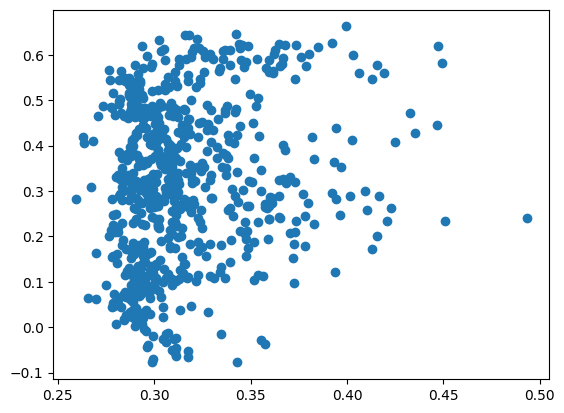

In [491]:
lin_model = LinearRegression().fit(X,y)
lin_pred = lin_model.predict(X)
plt.scatter(lin_pred,y)

## KNeighborsRegressor()
Here we simple see that there is some correlation between the predicted model **pred** and our prediction vector **y**

In [492]:
model = KNeighborsRegressor().fit(X,y)
pred = model.predict(X)


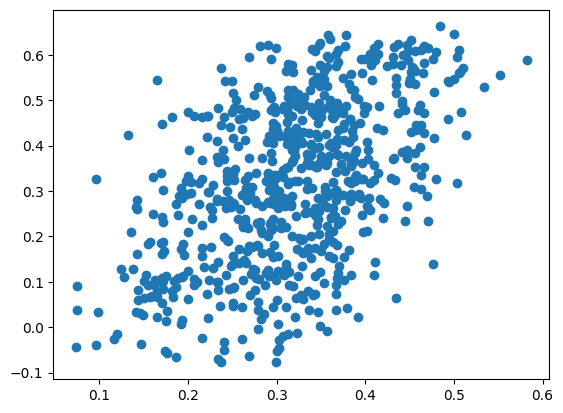

In [493]:
plt.scatter(pred,y)

### Pipeline
Let us do some preprocessing and then create a pipline where we do the model

Here how ever the model is able to predict on the same data it was trained on.

The idea is to train the data on a random subset of the data and judge how well the model predicts on the remaining subset

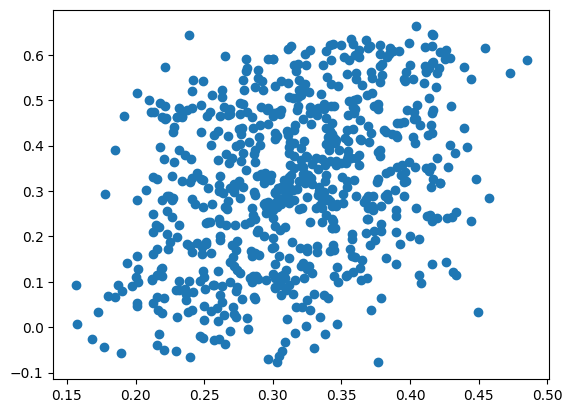

In [553]:

model = KNeighborsRegressor().fit(X,y)

pipe = Pipeline([
    ('scale',RobustScaler()),
    ('model',KNeighborsRegressor(n_neighbors=12))

])
pipe.fit(X,y)

predict = pipe.predict(X)
plt.scatter(predict,y)

### A Gridsearch Cross Validation model 

In [550]:
x = list(range(16))
x = x[1:]
print(x)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [551]:
grid_model = GridSearchCV(
    estimator=pipe,
    param_grid={'model__n_neighbors':x},
    cv=3
)

In [552]:
grid_model.fit(X,y)
df = pd.DataFrame(grid_model.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002964,8.418895e-04,0.001421,0.000167,1,{'model__n_neighbors': 1},-0.495917,-4.627669,-4.682095,-3.268560,1.960681,15
1,0.002225,8.361852e-05,0.001219,0.000079,2,{'model__n_neighbors': 2},-0.353227,-3.634062,-2.706668,-2.231319,1.380926,14
2,0.001835,3.805564e-05,0.001166,0.000094,3,{'model__n_neighbors': 3},-0.286680,-3.228216,-2.167555,-1.894150,1.216339,13
3,0.001532,9.975037e-05,0.000933,0.000077,4,{'model__n_neighbors': 4},-0.238294,-3.236401,-2.014046,-1.829580,1.230903,12
4,0.001384,1.219699e-04,0.000866,0.000079,5,{'model__n_neighbors': 5},-0.217799,-3.120538,-2.017668,-1.785335,1.196371,11
5,0.001208,2.485354e-06,0.000787,0.000005,6,{'model__n_neighbors': 6},-0.201027,-3.017105,-1.896425,-1.704852,1.157612,10
6,0.001186,2.666240e-05,0.000844,0.000078,7,{'model__n_neighbors': 7},-0.189147,-2.892642,-1.744715,-1.608835,1.107872,9
7,0.001202,1.009290e-04,0.000789,0.000023,8,{'model__n_neighbors': 8},-0.209728,-2.886610,-1.586140,-1.560826,1.092979,8
8,0.001095,1.927540e-05,0.000770,0.000018,9,{'model__n_neighbors': 9},-0.192182,-2.804505,-1.594865,-1.530517,1.067447,7
9,0.001178,1.077749e-04,0.000796,0.000037,10,{'model__n_neighbors': 10},-0.182322,-2.768571,-1.556509,-1.502468,1.056523,6
